In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

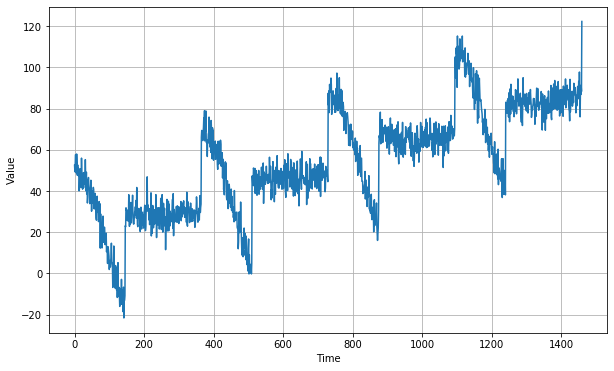

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    # Just an arbitrary pattern, you can change it if you wish
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    # repeat the same pattern at each period
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def white_noise(time,noise_level,seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude=40
series=seasonality(time,period=365,amplitude=amplitude)

slope=0.05
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

noise_level=5
noise=white_noise(time,noise_level,seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series);

In [3]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [13]:
time_valid.shape

(461,)

In [15]:
x_valid.shape

(461,)

In [16]:
time_train.shape

(1000,)

In [17]:
x_train.shape

(1000,)

In [4]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [18]:
def sequnetial_window_dataset(series,window_size):
    series=tf.expand_dims(series, axis=-1)
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=window_size,drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset=dataset.map(lambda window: (window[:-1],window[1:]))
    return dataset.batch(1).prefetch(1)

In [19]:
for x_batch, y_batch in sequnetial_window_dataset(tf.range(10),3):
    print (x_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [21]:
# tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=sequnetial_window_dataset(x_train,window_size)
#valid_set=sequnetial_window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100,return_sequences=True, stateful=True,
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.LSTM(100,return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7*10**(epoch/30))

reset_states=ResetStatesCallback()

optimizers=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

# model.fit(train_set,epochs=100,validation_data=valid_set)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [23]:
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 4s 27ms/step - loss: 72.5386 - mae: 73.0386
Epoch 2/100
33/33 [==============================] - 1s 21ms/step - loss: 19.7578 - mae: 20.2518
Epoch 3/100
33/33 [==============================] - 1s 20ms/step - loss: 18.9129 - mae: 19.4089
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 11.7569 - mae: 12.2488
Epoch 5/100
33/33 [==============================] - 1s 19ms/step - loss: 12.3288 - mae: 12.8237
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 11.0155 - mae: 11.5086
Epoch 7/100
33/33 [==============================] - 1s 18ms/step - loss: 9.7032 - mae: 10.1892
Epoch 8/100
33/33 [==============================] - 1s 19ms/step - loss: 8.7679 - mae: 9.2479
Epoch 9/100
33/33 [==============================] - 1s 21ms/step - loss: 8.2086 - mae: 8.6931
Epoch 10/100
33/33 [==============================] - 1s 19ms/step - loss: 7.7449 - mae: 8.2270
Epoch 11/100
33/33 [================

33/33 [==============================] - 1s 21ms/step - loss: 11.8735 - mae: 12.3608
Epoch 86/100
33/33 [==============================] - 1s 21ms/step - loss: 9.5847 - mae: 10.0669
Epoch 87/100
33/33 [==============================] - 1s 19ms/step - loss: 13.5410 - mae: 14.0321
Epoch 88/100
33/33 [==============================] - 1s 21ms/step - loss: 12.4894 - mae: 12.9845
Epoch 89/100
33/33 [==============================] - 1s 22ms/step - loss: 8.9147 - mae: 9.4012
Epoch 90/100
33/33 [==============================] - 1s 21ms/step - loss: 17.8181 - mae: 18.3134
Epoch 91/100
33/33 [==============================] - 1s 22ms/step - loss: 11.8177 - mae: 12.3062
Epoch 92/100
33/33 [==============================] - 1s 22ms/step - loss: 9.0542 - mae: 9.5441
Epoch 93/100
33/33 [==============================] - 1s 19ms/step - loss: 12.9771 - mae: 13.4681
Epoch 94/100
33/33 [==============================] - 1s 19ms/step - loss: 12.9042 - mae: 13.4001
Epoch 95/100
33/33 [==================

[1e-08, 0.0001, 0, 30]

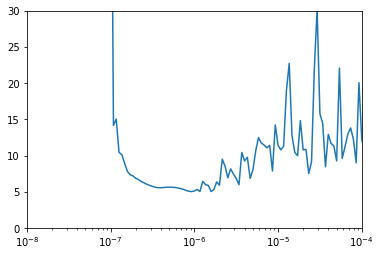

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=sequnetial_window_dataset(x_train,window_size)
valid_set=sequnetial_window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100,return_sequences=True, stateful=True,
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.LSTM(100,return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

optimizers=tf.keras.optimizers.SGD(lr=5e-7,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=["mae"])
reset_states=ResetStatesCallback()

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=250,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

# model.fit(train_set,epochs=100,validation_data=valid_set)

# history=model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/250
33/33 [==============================] - 5s 60ms/step - loss: 49.4821 - mae: 49.9798 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/250
33/33 [==============================] - 1s 27ms/step - loss: 19.0885 - mae: 19.5854 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/250
33/33 [==============================] - 1s 27ms/step - loss: 13.5866 - mae: 14.0785 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/250
33/33 [==============================] - 1s 28ms/step - loss: 12.4568 - mae: 12.9486 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/250
33/33 [==============================] - 1s 27ms/step - loss: 8.5582 - mae: 9.0502 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/250
33/33 [==============================] - 1s 23ms/step - loss: 8.3435 - mae: 8.8318 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/250
33/33 [==============================] - 1s 23ms/step - loss: 6.2385 - mae: 6.7184 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/250
33/33 [==============================] - 1s

33/33 [==============================] - 1s 24ms/step - loss: 4.7653 - mae: 5.2432 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/250
33/33 [==============================] - 1s 23ms/step - loss: 4.7566 - mae: 5.2343 - val_loss: 7.7333 - val_mae: 8.2206
Epoch 64/250
33/33 [==============================] - 1s 23ms/step - loss: 4.7515 - mae: 5.2289 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/250
33/33 [==============================] - 1s 22ms/step - loss: 4.7483 - mae: 5.2255 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/250
33/33 [==============================] - 1s 22ms/step - loss: 4.7452 - mae: 5.2224 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/250
33/33 [==============================] - 1s 23ms/step - loss: 4.7415 - mae: 5.2185 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/250
33/33 [==============================] - 1s 24ms/step - loss: 4.7357 - mae: 5.2126 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/250
33/33 [==============================] - 1s 25ms/step - loss: 4.7267 

33/33 [==============================] - 1s 25ms/step - loss: 4.4598 - mae: 4.9340 - val_loss: 6.3980 - val_mae: 6.8793
Epoch 124/250
33/33 [==============================] - 1s 24ms/step - loss: 4.4655 - mae: 4.9403 - val_loss: 6.3476 - val_mae: 6.8285
Epoch 125/250
33/33 [==============================] - 1s 25ms/step - loss: 4.4736 - mae: 4.9488 - val_loss: 6.2877 - val_mae: 6.7682
Epoch 126/250
33/33 [==============================] - 1s 29ms/step - loss: 4.4810 - mae: 4.9569 - val_loss: 6.2280 - val_mae: 6.7075
Epoch 127/250
33/33 [==============================] - 1s 23ms/step - loss: 4.4859 - mae: 4.9622 - val_loss: 6.1626 - val_mae: 6.6409
Epoch 128/250
33/33 [==============================] - 1s 23ms/step - loss: 4.4883 - mae: 4.9647 - val_loss: 6.1093 - val_mae: 6.5874
Epoch 129/250
33/33 [==============================] - 1s 23ms/step - loss: 4.4877 - mae: 4.9643 - val_loss: 6.0682 - val_mae: 6.5464
Epoch 130/250
33/33 [==============================] - 1s 24ms/step - loss: 

33/33 [==============================] - 1s 24ms/step - loss: 4.3684 - mae: 4.8463 - val_loss: 5.8716 - val_mae: 6.3484
Epoch 185/250
33/33 [==============================] - 1s 24ms/step - loss: 4.3645 - mae: 4.8423 - val_loss: 5.8624 - val_mae: 6.3390
Epoch 186/250
33/33 [==============================] - 1s 29ms/step - loss: 4.3611 - mae: 4.8386 - val_loss: 5.8582 - val_mae: 6.3347
Epoch 187/250
33/33 [==============================] - 1s 23ms/step - loss: 4.3579 - mae: 4.8351 - val_loss: 5.8564 - val_mae: 6.3328
Epoch 188/250
33/33 [==============================] - 1s 24ms/step - loss: 4.3554 - mae: 4.8323 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 189/250
33/33 [==============================] - 1s 24ms/step - loss: 4.3534 - mae: 4.8301 - val_loss: 5.8564 - val_mae: 6.3327
Epoch 190/250
33/33 [==============================] - 1s 23ms/step - loss: 4.3521 - mae: 4.8285 - val_loss: 5.8560 - val_mae: 6.3323
Epoch 191/250
33/33 [==============================] - 1s 24ms/step - loss: 

33/33 [==============================] - 1s 24ms/step - loss: 4.3134 - mae: 4.7868 - val_loss: 5.6955 - val_mae: 6.1739
Epoch 246/250
33/33 [==============================] - 1s 24ms/step - loss: 4.3087 - mae: 4.7818 - val_loss: 5.7408 - val_mae: 6.2181
Epoch 247/250
33/33 [==============================] - 1s 25ms/step - loss: 4.3037 - mae: 4.7766 - val_loss: 5.6107 - val_mae: 6.0894
Epoch 248/250
33/33 [==============================] - 1s 26ms/step - loss: 4.3082 - mae: 4.7801 - val_loss: 5.8498 - val_mae: 6.3266
Epoch 249/250
33/33 [==============================] - 1s 25ms/step - loss: 4.3059 - mae: 4.7809 - val_loss: 5.5424 - val_mae: 6.0214
Epoch 250/250
33/33 [==============================] - 1s 24ms/step - loss: 4.3379 - mae: 4.8130 - val_loss: 5.6822 - val_mae: 6.1598


In [26]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [32]:
rnn_forecast=model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast=rnn_forecast[0, split_time - 1:-1, 0]

In [33]:
rnn_forecast

array([63.727093, 65.293396, 65.760605, 65.05797 , 63.683754, 64.58894 ,
       64.64601 , 65.39892 , 65.554924, 66.250725, 64.59634 , 66.059685,
       65.41762 , 67.47263 , 65.16469 , 67.04329 , 66.11788 , 64.49643 ,
       63.639133, 63.181313, 63.81519 , 64.304474, 63.17451 , 63.265354,
       65.966194, 67.19606 , 66.590706, 65.80888 , 65.38778 , 65.70499 ,
       63.623302, 63.40405 , 61.064922, 62.466133, 63.49305 , 62.72355 ,
       65.01303 , 62.687534, 61.04538 , 62.212814, 63.871574, 65.78886 ,
       64.39442 , 65.7173  , 65.01628 , 64.49141 , 65.502106, 65.80572 ,
       62.994682, 65.36305 , 66.53157 , 64.82804 , 65.24856 , 65.51914 ,
       65.4104  , 64.272   , 63.375027, 63.601124, 65.209564, 65.45515 ,
       64.53628 , 65.49988 , 60.88458 , 63.674973, 61.151665, 61.71479 ,
       60.82769 , 60.040306, 62.7782  , 62.330784, 63.363075, 63.49283 ,
       64.352295, 64.40183 , 62.62777 , 64.58232 , 63.74039 , 61.845146,
       62.195663, 64.73303 , 65.57019 , 64.76098 , 

In [28]:
rnn_forecast.shape

(461,)

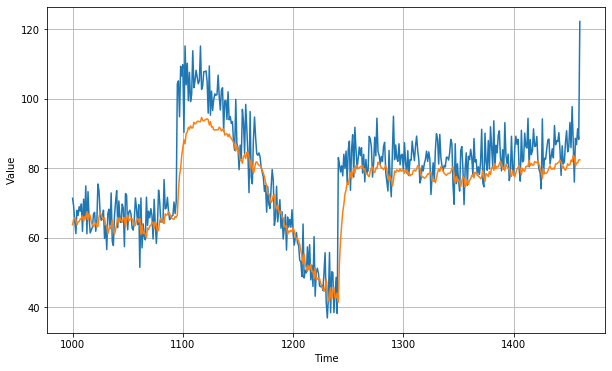

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid);
plot_series(time_valid, rnn_forecast);

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.144307